# BioRxiv paper analysis - Can we predict which paper gets published?

## Project Overview

BioRxiv is one of the largest pre-print depositories for biology academic research articles. Researchers may choose to upload their articles to BioRxiv before submitting them to a journal for publication.
<br><br>
In this project, I would like to can use machine learning techniques to predict if BioRxiv preprints get published eventually based on the information and metadata provided by BioRxiv.

In [150]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Retrieving data from BioRxiv api

To build up an initial dataset, I am only retrieving the first 10,000 records from bioRxiv between 2015-01-01 and 2022-01-02

In [ ]:
# biorxiv_data = []
# for i in range (0, 10000, 100):
#     response = requests.get("https://api.biorxiv.org/details/biorxiv/2015-01-01/2022-01-02/"+str(i)+"/json")
#     json_data = response.json()
#     data_to_save = json_data['collection']
#     biorxiv_data.append(data_to_save)

In [ ]:
# with open("biorxiv.json", "w") as biorxiv:
#     json.dump(biorxiv_data, biorxiv, indent = 6) 

In [ ]:
# data_df_all = pd.DataFrame()
# for i in range (len(biorxiv_data)):
#     data_df_all = pd.concat([data_df_all, pd.json_normalize(biorxiv_data[i])])

## Initial Data Cleaning and Exploration

### Removing duplicated entries and dropping some columns 

In [ ]:
#Sorting the papers by doi and version, then removing the duplicated papers and only keep the latest version
data_df = data_df_all.sort_values(by=['doi', 'version'], ascending=[True, False], ignore_index=True)
data_df = data_df_all.drop_duplicates(subset=['doi'], keep='first', ignore_index=True)

In [127]:
# Checking if there are any duplicated papers left
data_df.duplicated(subset=['doi']).sum()

0

In [367]:
# Dropping 'jatsxml' and 'server' columns as they do not provide additional information
data_df = data_df.drop(columns=['jatsxml', 'server'])

In [369]:
# Adding a new column named 'published' to indicate whether the paper is published
data_df = data_df.rename(columns={"published":"published_link"})

In [371]:
data_df['published'] = np.where(data_df['published_link'] != 'NA', 1, 0)

In [372]:
data_df.head()

,doi,title,authors,author_corresponding,author_corresponding_institution,date,version,type,license,category,abstract,published_link,published
0,10.1101/001685,"Stem cells in Nanomia bijuga (Siphonophora), a...",Stefan Siebert;Freya E. Goetz;Samuel H. Church...,Stefan Siebert,Brown University,2015-03-16,2,New Results,cc_by_nc_nd,Developmental biology,BackgroundSiphonophores (Hydrozoa) have unpara...,10.1186/s13227-015-0018-2,1
1,10.1101/001016,Predictability of adaptive evolution under the...,Sandeep Venkataram;Diamantis Sellis;Dmitri A P...,Dmitri A Petrov,Stanford University,2015-07-28,4,New Results,cc_by_nc_nd,Evolutionary biology,Predicting the course of evolution is critical...,NA,0
2,10.1101/002485,Epistasis within the MHC contributes to the ge...,Ben Goudey;Gad Abraham;Eder Kikianty;Qiao Wang...,Michael Inouye,"Centre for Systems Genomics, School of BioScie...",2015-08-11,4,New Results,cc_by,Genomics,Epistasis has long been thought to contribute ...,NA,0
3,10.1101/002634,mangal - making ecological network analysis si...,Timothée E Poisot;Benjamin Baiser;Jennifer A D...,Timothée E Poisot,Université du Québec à Rimouski,2015-02-24,3,New Results,cc_by,Ecology,The study of ecological networks is severely l...,10.1111/ecog.00976,1
4,10.1101/002782,Large-scale non-targeted metabolomic profiling...,Andrea Ganna;Tove Fall;Samira Salihovic;Woojoo...,Erik Ingelsson,Uppsala University,2015-05-28,3,New Results,cc_by_nd,Bioinformatics,Metabolomic profiling is an emerging technique...,NA,0


### Cleaning up the 'category' column

In [373]:
data_df = data_df.copy().dropna()

In [374]:
# Removing any leading and trailing space and capitalize the first letter
data_df['category'] = data_df['category'].str.capitalize().str.strip()

In [375]:
# Renaming any blank categories to 'Other'
data_df.loc[data_df['category'] == '', 'category'] = 'Other'

### Splitting the dataset into 'published' and 'unpublished' papers for some quick visualizations

In [376]:
published_df = data_df[data_df['published'] == 1].reset_index(drop=True)

In [377]:
unpublished_df = data_df[data_df['published'] == 0].reset_index(drop=True)

### Published paper count for different categories

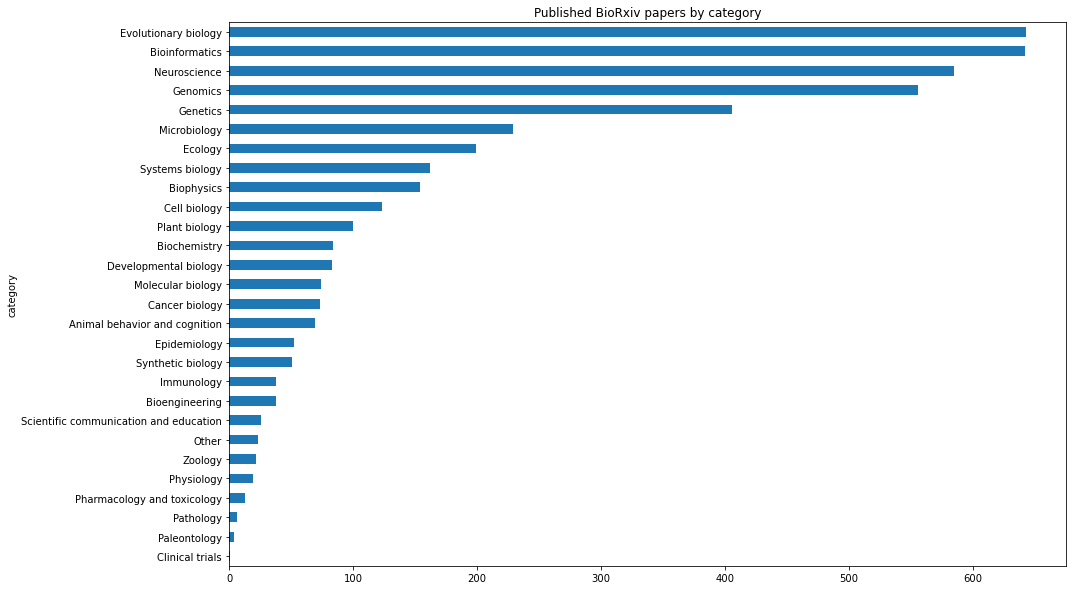

In [378]:
# Plotting the number of published papers in each category
plt.figure(figsize=(15,10))
height=published_df.groupby('category')['doi'].count().sort_values().plot(kind='barh')
plt.title('Published BioRxiv papers by category')
plt.show()

### Exploring titles to find the most frequently used words

In [212]:
# Building a stopwords set to remove stop words and common connection words from the title words list
from nltk.corpus import stopwords
s=set(stopwords.words('english'))

In [416]:
# Adding some words to the stopwords list
s.update(['data', 'using', 'analysis', 'show', 'also', 'two', 'used', 'reveals'])

In [417]:
title_words = pd.Series(x.split() for x in published_df['title']).explode().str.lower()

# Removing common stopwords from the title word list
title_words_clean = pd.Series(word for word in title_words if word not in s).value_counts()

In [608]:
title_words_clean[0:10]

gene          265
human         248
genetic       234
genome        202
evolution     184
cell          168
expression    156
sequencing    148
model         130
dynamics      130
dtype: int64

### Exploring abstracts to find the most frequently used words

In [419]:
abs_words = pd.Series(x.split() for x in published_df['abstract']).explode().str.lower()

# Removing common stopwords from the title word list
abs_words_clean = pd.Series(word for word in abs_words if word not in s).value_counts()

In [609]:
abs_words_clean[0:10]

gene          2239
genetic       2120
model         1862
cell          1688
results       1647
genes         1607
expression    1495
different     1449
population    1328
however,      1311
dtype: int64

### Published paper count based on institutions

<AxesSubplot:>

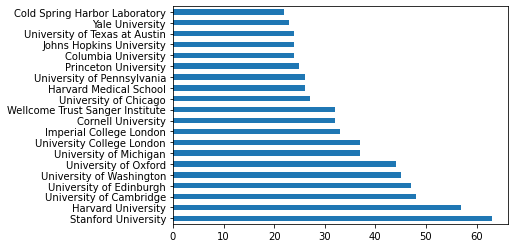

In [469]:
published_df['author_corresponding_institution'].value_counts()[0:20].plot.barh()

### Retrieving citation counts for each published article using the Scopus API

In [342]:
from datetime import timedelta
from ratelimit import limits, sleep_and_retry
import requests

@sleep_and_retry
@limits(calls=10, period=timedelta(seconds=5).total_seconds())

def get_citation():
    for i in range (0, published_df.shape[0]):
        doi = published_df['published'][i]
        query="DOI("+doi+")&field=citedby-count"
        response = requests.get("https://api.elsevier.com/content/search/scopus?query="+query, headers = headers)
        if('error' in response.json()['search-results']['entry'][0].keys()):
            published_df.loc[i, ('citation_count')] = 0
        else: 
            published_df.loc[i, ('citation_count')] = int(response.json()['search-results']['entry'][0]['citedby-count'])
        
        response.raise_for_status()

In [343]:
#get_citation()

In [599]:
#published_df['citation_count'].value_counts().plot.hist(bins = 15)

In [347]:
#published_df.to_csv('published_df.csv')

In [357]:
published_df[published_df['citation_count'] == published_df['citation_count'].max()]

,doi,title,authors,author_corresponding,author_corresponding_institution,date,version,type,license,category,jatsxml,abstract,published,server,citation_count
702,10.1101/024034,DADA2: High resolution sample inference from a...,Benjamin J Callahan;Paul J McMurdie;Michael J ...,Benjamin J Callahan,Stanford University,2015-08-06,1,New Results,cc_by_nc_nd,Bioinformatics,https://www.biorxiv.org/content/early/2015/08/...,Microbial communities are commonly characteriz...,10.1038/nmeth.3869,biorxiv,6616


### Further cleaning up for machine learning applications

In [561]:
data_reg = data_df.copy()

In [562]:
data_reg['title_len'] = data_reg['title'].apply(lambda x: len(x.split()))

In [563]:
data_reg['authors_len'] = data_reg['authors'].apply(lambda x: len(x.split(';'))-1)

In [564]:
data_reg['title_w_top_50_kw'] = data_reg['title'].apply(lambda x: sum(el in title_words_clean[0:50] for el in x.split()))

In [565]:
data_reg['top_100_inst'] = data_reg['author_corresponding_institution'].apply(lambda x: 1 if x in published_df['author_corresponding_institution'].value_counts()[0:101] else 0)

In [566]:
data_reg['top_100_auth'] = data_reg['author_corresponding'].apply(lambda x: 1 if x in published_df['author_corresponding'].value_counts()[0:101] else 0)

In [567]:
data_reg['date'] = pd.to_datetime(data_reg['date'])

In [568]:
data_reg['month'] = data_reg['date'].dt.month_name()

In [569]:
data_reg['day'] = data_reg['date'].dt.day_name()

In [573]:
data_reg = pd.get_dummies(data=data_reg, columns=['category', 'month','day'], drop_first=True)

In [576]:
data_reg = data_reg.drop(columns=['doi', 'title', 'authors', 'author_corresponding', 'author_corresponding_institution',
                       'date','version', 'type', 'license', 'abstract', 'published_link'])

In [577]:
data_reg

,published,title_len,authors_len,title_w_top_50_kw,top_100_inst,top_100_auth,category_Biochemistry,category_Bioengineering,category_Bioinformatics,category_Biophysics,...,month_May,month_November,month_October,month_September,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,1,13,7,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,9,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,12,10,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,7,10,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,9,13,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,1,10,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6356,0,12,13,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6357,1,3,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6358,1,15,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [531]:
from sklearn.model_selection import train_test_split

In [578]:
X_train, X_test, y_train, y_test = train_test_split(data_reg.loc[:, data_reg.columns!='published'], data_reg['published'], 
                                                    test_size=0.2, random_state=1)

In [593]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(solver='lbfgs', max_iter=400)

In [594]:
lm.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [595]:
pred = lm.predict(X_test)

In [596]:
pred

array([1, 1, 1, ..., 1, 1, 0])

In [603]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

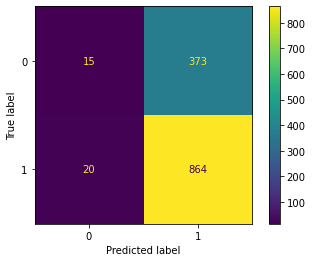

In [598]:
ConfusionMatrixDisplay.from_estimator(lm, X_test, y_test)

In [606]:
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(y_test, pred))

Accuracy: 0.6910377358490566
Precision: 0.698464025869038
Recall: 0.9773755656108597
F1 Score: 0.8147100424328146
